In [2]:
import os
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
remove_attention_failers = 0

In [3]:
test = []
def extract_basic_info(csv_path):
    df = pd.read_csv(csv_path)
    

    free_texts = df['explanation_box.text'].dropna().tolist()


    # Feedback (free text response about experiment)
    if 'feedback_text.text' in df.columns:
        feedback = df['feedback_text.text'].dropna().tolist()
    else:
        print(f"Missing 'feedback_text.text' in {os.path.basename(csv_path)}")
        fail_text = f"Missing 'feedback_text.text' in {os.path.basename(csv_path)}"
        test.append(fail_text)
        feedback = []

    #Actual food needed (food needed on each training trial)
    food_amount = df['food_amount'].dropna().tolist() [:-1]
    
    # Training trial stop time (time it took to finish the training loop)
    isi_values = df['ISI.stopped'].dropna().tolist()

    #Get the ISI value for the last training trial, store it
    trial_stop_time = isi_values[-1] if isi_values else np.nan

    #First row with a non-empty value in 'images_list', which shows the order of testing images presented
    images_row = df[df['images_list'].notna()].iloc[0] if not df[df['images_list'].notna()].empty else None

    #Turn the images from PNGs to names
    images = [img.split('/')[-1].replace('.png','') for img in images_row['images_list'].split(',')]

    #First row with a non-empty value in 'sliderRatings', which shows the ratings for testing images
    ratings_row = df[df['sliderRatings'].notna()].iloc[0] if not df[df['sliderRatings'].notna()].empty else None

    #Turn the ratings into floats split by commas
    ratings = [float(r) for r in ratings_row['sliderRatings'].strip('[]').split(',')]

    #Across the training trials, add information about features (what actual feature values were shown)
    train_tail = df['tail'].dropna().tolist() [:-1]
    train_shape = df['shape'].dropna().tolist() [:-1]
    train_color = df['color'].dropna().tolist() [:-1]

    #Across the training trials, add information about feature relevance
    train_categories =  df['category'].dropna().tolist() [:-1]
    train_tail = df['tail_rel'].dropna().tolist() [:-1]
    train_shape = df['shape_rel'].dropna().tolist() [:-1]
    train_color = df['color_rel'].dropna().tolist() [:-1]

    #Extracting the relevant and irrelevant feature dimension info
    dims = {}
    cols = ['relevant_dim_1', 'relevant_dim_2', 'irrelevant_dim', 
            'color_high', 'color_low', 
            'shape_high', 'shape_low', 
            'tail_high', 'tail_low']

    for col in cols:
        vals = df[col].dropna().unique()

        if len(vals) == 0:
            dims[col] = np.nan
            print(f"Warning: No values found in {col}")

        elif len(vals) == 1:
            dims[col] = vals[0]

        else:
            warnings.warn(
                f"Multiple values found in {col}: {vals}"
            )
            dims[col] = vals[0] 

    print(dims)

    #Categories for the testing images, in the order shown
    test_categories = images_row['testing_categories'].split(',')

    #Write condition (this is the unique identifier for a certain order of training trials)
    condition = images_row['condition'] if images_row is not None and 'condition' in images_row else np.nan

    #Add in the order of images during training
    training_image_order = [img.split('/')[-1].replace('.png','') 
                        for img in df['image_file'].dropna().tolist()] [:-1]
    
    #Updated code to get slider responses (subjective reports of feature relevance)
    slider_responses = {}
    features = ['shape', 'color', 'tail']

    for feat in features:
        # subset only rows of this feature
        sub = df[df['feature'] == feat]

        # 1. discrete
        disc = sub['discrete_slider.response']
        disc_val = disc[disc.notna() & (disc != "")].iloc[0] if (disc.notna() & (disc != "")).any() else np.nan
        print(disc_val)
        slider_responses[f'{feat}_discrete_slider.response'] = disc_val

        # 2. direction
        col = 'direction_response_label'

        if col not in sub.columns:
            #warnings.warn(
            #    f"Column '{col}' not found for feature '{feat}' in {os.path.basename(csv_path)}"
            #)
            dirc_val = np.nan
        else:
            dirc = sub[col]
            dirc_val = (
                dirc[dirc.notna() & (dirc != "")].iloc[0]
                if (dirc.notna() & (dirc != "")).any() and disc_val != 'No'
                else np.nan
            )

        slider_responses[f'{feat}_direction_slider.response'] = dirc_val


        # 3. continuous
        cont = sub['continuous_slider.response']
        cont_val = cont[cont.notna() & (cont != "")].iloc[0] if (cont.notna() & (cont != "")).any() and disc_val != 'No' else np.nan #only store continuous if discrete was "Yes"
        print(cont_val)
        slider_responses[f'{feat}_continuous_slider.response'] = cont_val

    #Adding attention check result
    att_rows = df[df['button_3_correct.numClicks'].notna()]
    if not att_rows.empty:
        att_val = att_rows.iloc[0]['button_3_correct.numClicks']
    else:
        att_val = np.nan
    attention_check = 1 if att_val == 1 else 0

    result = {
        'participant': os.path.basename(csv_path)[:3],
        'free_texts': free_texts,
        'feedback': feedback,
        'food_amount': food_amount,
        'trial_stop_time': trial_stop_time,
        'testing_image_order': images,
        'testing_responses': ratings,
        'training_categories': train_categories,
        'training_tail': train_tail,
        'training_shape': train_shape,
        'training_color': train_color,
        'testing_categories': test_categories,
        'conditionOrder': condition,
        'training_image_order': training_image_order,
        'attention_check': attention_check,
        **dims
        
    }
    result.update(slider_responses)
    return result

topdir = '/Users/sm6511/Desktop/Prediction-Accomodation-Exp'
study = 'Study1.0'
dates = [
    '2026-01-12',
    '2026-01-13',
    '2026-01-14',
]
datadir = os.path.join(topdir, f'data/{study}/Accommodate')
cleaneddir = os.path.join(topdir, f'data/{study}/Cleaned')
all_participants = []

for fname in os.listdir(datadir):
    if fname.endswith('.csv') and fname:
        participant_id = fname[:3]
        if not any(d in fname for d in dates):
            continue
        csv_path = os.path.join(datadir, fname)
        print(csv_path)
        info = extract_basic_info(csv_path)
        all_participants.append(info)

df_all = pd.DataFrame(all_participants)
if remove_attention_failers:
    df_all = df_all[df_all['attention_check'] == 1]
    df_all.to_csv(os.path.join(cleaneddir, f'{study}Accommodate.csv'), index=False)
else:
    df_all.to_csv(os.path.join(cleaneddir, f'{study}Accommodate.csv'), index=False)

print(df_all[df_all['attention_check'] == 1])
print(test)

/Users/sm6511/Desktop/Prediction-Accomodation-Exp/data/Study1.0/Accommodate/085_explain2_2026-01-12_13h36.11.660.csv
{'relevant_dim_1': 'color', 'relevant_dim_2': 'tail', 'irrelevant_dim': 'shape', 'color_high': 'B', 'color_low': 'Y', 'shape_high': 'C', 'shape_low': 'S', 'tail_high': 'N', 'tail_low': 'T'}
No
nan
Yes
6.0
Yes
3.0
/Users/sm6511/Desktop/Prediction-Accomodation-Exp/data/Study1.0/Accommodate/098_explain2_2026-01-12_14h38.29.935.csv
{'relevant_dim_1': 'shape', 'relevant_dim_2': 'tail', 'irrelevant_dim': 'color', 'color_high': 'B', 'color_low': 'Y', 'shape_high': 'C', 'shape_low': 'S', 'tail_high': 'N', 'tail_low': 'T'}
Yes
6.0
Yes
5.0
Yes
5.0
/Users/sm6511/Desktop/Prediction-Accomodation-Exp/data/Study1.0/Accommodate/112_explain2_2026-01-12_15h14.04.126.csv
{'relevant_dim_1': 'tail', 'relevant_dim_2': 'shape', 'irrelevant_dim': 'color', 'color_high': 'Y', 'color_low': 'B', 'shape_high': 'S', 'shape_low': 'C', 'tail_high': 'N', 'tail_low': 'T'}
Yes
2.0
No
nan
Yes
5.0
/Users/sm

In [4]:
print(df_all['conditionOrder'])

0       85
1       98
2      112
3       90
4       78
      ... 
145     75
146     54
147    139
148     16
149     69
Name: conditionOrder, Length: 150, dtype: int64


In [26]:
participant_id = '021'

row = df_all[df_all['participant'] == participant_id]

free_texts = row['free_texts'].iloc[0] 
feedback = row['feedback'].iloc[0]
print(f"Free text responses for participant {participant_id}:")
for i, text in enumerate(free_texts, 1):
    print(f"Response {i}: {text}")

print(f"\nFeedback for participant {participant_id}: {feedback}")


Free text responses for participant 021:
Response 1: yellow
Response 2: blue
Response 3: square
Response 4: straight
Response 5: curly
Response 6: blue straight'
Response 7: square curly
Response 8: yellow square
Response 9: square
Response 10: circle
Response 11: straight blue
Response 12: yellow square
Response 13: straight
Response 14: circle
Response 15: circle curly
Response 16: square straight
Response 17: blue circle
Response 18: blue straight
Response 19: circle yellow
Response 20: square straight
Response 21: circle straight
Response 22: square curly
Response 23: yellow square
Response 24: curly square

Feedback for participant 021: []


In [ ]:
stim_info = [
    {
        'stimulus': stim,
        'rating': rating,
        'category': testing_categories
    }
    for stim, rating in zip(basic_info['image_order'], basic_info['ratings'])
]
df_stim = pd.DataFrame(stim_info)
avg_per_category = df_stim.groupby('category')['rating'].mean()
plt.figure(figsize=(6,4))
bars = plt.bar(avg_per_category.index, avg_per_category.values, color=['red','green','blue'], alpha=0.7)

# Add text labels on top of bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f"{bar.get_height():.2f}", ha='center')

plt.ylabel('Average Rating')
plt.title('Average food ratings by Stimulus Category')
plt.ylim(0, 10)
plt.show()

<Figure size 640x480 with 0 Axes>

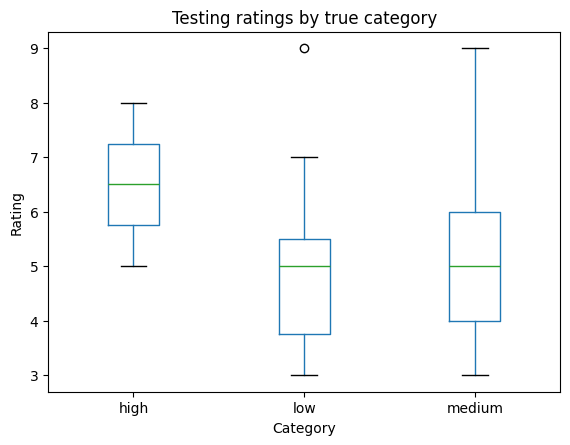

In [19]:
import pandas as pd
import numpy as np

def explode_testing(df):
    rows = []
    for _, row in df.iterrows():
        cats = row['testing_categories']
        ratings = row['testing_responses']

        if not isinstance(cats, list) or not isinstance(ratings, list):
            continue

        for i, (c, r) in enumerate(zip(cats, ratings)):
            rows.append({
                'participant': row['participant'],
                'trial': i,
                'category': c,
                'rating': r
            })

    return pd.DataFrame(rows)

df_test_long = explode_testing(df_all)

df_test_long.groupby('category')['rating'].agg(
    mean='mean',
    std='std',
    n='count'
).reset_index()
import matplotlib.pyplot as plt

plt.figure()
df_test_long.boxplot(
    column='rating',
    by='category',
    grid=False
)
plt.suptitle('')
plt.title('Testing ratings by true category')
plt.ylabel('Rating')
plt.xlabel('Category')
plt.show()



<Figure size 640x480 with 0 Axes>

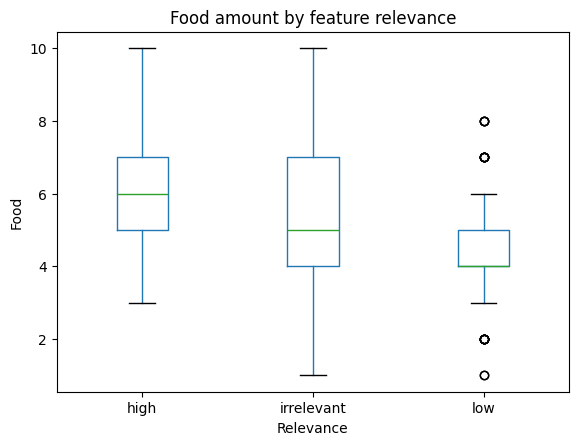

In [25]:
def explode_training(df):
    rows = []

    for _, row in df.iterrows():
        n_trials = len(row['food_amount'])

        for t in range(n_trials):
            rows.append({
                'participant': row['participant'],
                'trial': t,
                'category': row['training_categories'][t],
                'food': row['food_amount'][t],
                'tail_rel': row['training_tail'][t],
                'shape_rel': row['training_shape'][t],
                'color_rel': row['training_color'][t]
            })

    return pd.DataFrame(rows)

df_train_long = explode_training(df_all)
def get_relevance(code):
    if isinstance(code, str):
        if code.startswith('R'):
            return 'high'
        elif code.startswith('L'):
            return 'low'
        elif code.startswith('I'):
            return 'irrelevant'
    return np.nan

for feat in ['tail', 'shape', 'color']:
    df_train_long[f'{feat}_relevance'] = df_train_long[f'{feat}_rel'].apply(get_relevance)

df_rel_long = pd.melt(
    df_train_long,
    id_vars=['participant', 'trial', 'food'],
    value_vars=['tail_relevance', 'shape_relevance', 'color_relevance'],
    var_name='feature',
    value_name='relevance'
)

df_rel_long.groupby('relevance')['food'].agg(
    mean='mean',
    std='std',
    n='count'
)
plt.figure()
df_rel_long.boxplot(
    column='food',
    by='relevance',
    grid=False
)
plt.suptitle('')
plt.title('Food amount by feature relevance')
plt.ylabel('Food')
plt.xlabel('Relevance')
plt.show()



In [23]:
df_rel_long.groupby('relevance')['food'].mean()


relevance
high          6.303922
irrelevant    5.430000
low           4.520408
Name: food, dtype: float64

In [26]:
df_train_long.groupby('category')['food'].agg(
    mean='mean',
    std='std',
    n='count'
).reset_index()


,category,mean,std,n
0,high,7.230769,1.582598,26
1,low,3.666667,1.239448,24
2,medium,5.340000,1.408574,50


<Figure size 640x480 with 0 Axes>

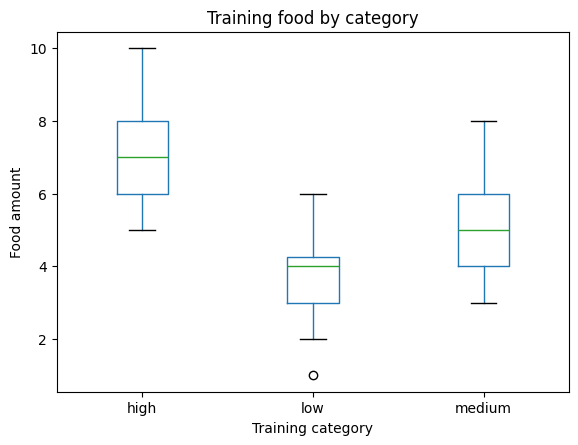

In [27]:
import matplotlib.pyplot as plt

plt.figure()
df_train_long.boxplot(
    column='food',
    by='category',
    grid=False
)
plt.suptitle('')
plt.title('Training food by category')
plt.ylabel('Food amount')
plt.xlabel('Training category')
plt.show()
